# ReAct Agent Architecture

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [1]:
import os
import gradio as gr
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

from Creds import Creds
my_creds = Creds()

All API Keys and Tokens are loaded.


# 1. Chat Models

In [2]:
# GPT
load_dotenv(override=True)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "type-your-key-here")
gpt = "gpt-4o-mini"

# Gemini
GOOGLE_API_KEY = my_creds.google_api_key
GOOGLE_BASE_URL = my_creds.google_base_url
gemini = "gemini-2.0-flash"

# Llama (perform poorly)
OLLAMA_API_KEY = my_creds.ollama_api_key
OLLAMA_BASE_URL = my_creds.ollama_base_url
llama = "llama3.2"

def set_chat_models(model: str, temperature: float=0.5) -> ChatOpenAI:
    if model == gpt:
        return ChatOpenAI(model=gpt, temperature=temperature)
    elif model == llama:
        return ChatOllama(model=llama, temperature=temperature)
        # return ChatOpenAI(model=llama, temperature=temperature, api_key=OLLAMA_API_KEY, base_url=OLLAMA_BASE_URL) # via ChatOpenAI
    elif model == gemini:
        return ChatGoogleGenerativeAI(model=gemini, temperature=temperature, google_api_key=GOOGLE_API_KEY)
    else:
        raise ValueError(f"Model unknown: {model}")

llm = set_chat_models(llama)
llm

ChatOllama(model='llama3.2', temperature=0.5)

# 2. Bind Tools

In [3]:
def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def subtract(a: int, b: int) -> int:
    """Subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a - b

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, subtract, multiply, divide]
try:
    if llm.model_name:
        print("ChatOpenAI detected.")
        llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False) # Set parallel tool calling to false as math generally is done sequentially.
except:
    print("ChatGoogleGenerativeAI or ChatOllama LLMs detected.")
    llm_with_tools = llm.bind_tools(tools)

ChatGoogleGenerativeAI or ChatOllama LLMs detected.


# 3. Build a Graph

In [4]:
system_prompt = "You are a helpful assistant tasked with performing arithmetic on a set of inputs."

llama_system_prompt = " If the user's prompt does **not** require using any of the functions \
(e.g., casual conversation, greetings, small talk, or general knowledge), respond normally in plain text. \
Only call functions when absolutely necessary."

try:
    if llm.model_name == llama:
        system_prompt += llama_system_prompt
except:
    if llm.model == llama:
        system_prompt += llama_system_prompt

system_message = SystemMessage(content=system_prompt)
system_message

SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs. If the user's prompt does **not** require using any of the functions (e.g., casual conversation, greetings, small talk, or general knowledge), respond normally in plain text. Only call functions when absolutely necessary.", additional_kwargs={}, response_metadata={})

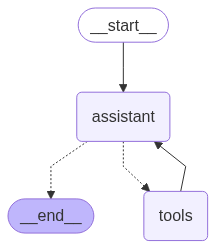

In [5]:
# Build a graph
builder = StateGraph(MessagesState)

# Nodes
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Testing the Graph

In [6]:
%%time

# 4 tambah 5, lalu kurang 7, kali 5.
# Add 3 and 4. Multiply the output by 2. Divide the output by 5.
# Add 13 and 7. Multiply the output by 4. Divide the output by 5. Last, substact the output with 10.
# Add 3 and 4. Next, multiply the output by 2. Next, divide the output by 5. # works for llama

messages = [HumanMessage(content="Add 3 and 4. Next, multiply the output by 2. Next, divide the output by 5.")]
messages = react_graph.invoke({"messages": messages})

for message in messages["messages"]:
    message.pretty_print()

# Note: llama3.2 model from Ollama performs poorly.

================================ Human Message =================================

Add 3 and 4. Next, multiply the output by 2. Next, divide the output by 5.
================================== Ai Message ==================================
Tool Calls:
  multiply (c061775f-6219-46a2-be29-81aeac2bef13)
 Call ID: c061775f-6219-46a2-be29-81aeac2bef13
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

To find the final answer, we need to perform two more operations.

First, multiply 14 by 2:

14 × 2 = 28

Next, divide 28 by 5:

28 ÷ 5 = 5.6
CPU times: total: 78.1 ms
Wall time: 4.31 s


# UI

In [8]:
def chat(message, history):
    messages = [HumanMessage(content=message)]
    messages = react_graph.invoke({"messages": messages})
    ai_messages = [m for m in messages["messages"] if isinstance(m, AIMessage)]
    return ai_messages[-1].content if ai_messages else "No AI response."

In [9]:
view = gr.ChatInterface(
    fn=chat,
    title="LangGraph Arithmetic Assistant",
    type="messages"
).launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
